In [1]:
## Finding soln to coupled eq.s
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy.special import hyp2f1

In [17]:
# Define Ea^2 = H/H0 a^2 (a suqared to avoid singularity
def Easquared(a,cosmo1):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
    
    return np.sqrt(Omega_m*a + (Omega_r + alpha_C) + Omega_k*a**(2) + Omega_lambda*a**(4))

# Approx for small scale, horizon crossing
def phi_funct_highk(a,k,cosmo):
    return 3*(np.sin(a*k/np.sqrt(3*(cosmo[-2]+cosmo[-1]))) - (a*k/np.sqrt(3*(cosmo[-2]+cosmo[-1])))*\
                   np.cos(a*k/np.sqrt(3*(cosmo[-2]+cosmo[-1]))))/(a*k/np.sqrt(3*(cosmo[-2]+cosmo[-1])))**3\
        + cosmo[-1]*0.141833*3*np.sqrt(3)/((cosmo[-1]+cosmo[-2])*(k**3 *a**3))
    
def phi_funct_lowk(a,k,cosmo):
    y = a*(cosmo[0]+cosmo[1])/(cosmo[-1]+cosmo[-2])
    kappa = cosmo[-1]/(2*(cosmo[-2]+cosmo[-1]))
    return -(3-4*kappa)*((y/(y+1))**(4*kappa) * y**(3-4*kappa)*((12*kappa+1)*np.sqrt(1+y) * hyp2f1(0.5-4*kappa,3-4*kappa,4-4*kappa,-y) +(4*kappa-3)*(y+1)**(4*kappa))/\
           ((4*kappa-3)*(8*kappa-1)*np.sqrt(y+1)))*np.sqrt(1+y)/(y**3 * 2)

def functInt(x,A,B):
    return np.exp(B*x)*x**(2-4*A)*(1+x)**(4*A -B-3/2)*(3*x+4)

def phi_funct_firstorderk(a,k,cosmo):
    y = a*(cosmo[0]+cosmo[1])/(cosmo[-1]+cosmo[-2])
    A = cosmo[-1]/(2*(cosmo[-2]+cosmo[-1]))
    #B = (cosmo[-1]+cosmo[-2])*k**2 /(3*(cosmo[0]+cosmo[1])**2)
    B=0
    C = 1
    Int = np.zeros(len(a))
    for i in range(len(a)):
        Int[i] = sc.integrate.quad(lambda x: functInt(x,A,B), 1, y[i])[0]
    return Int*C*y**(4*A)*np.exp(-B*y)*(1+y)**(B-4*A)*np.sqrt(1+y)/y**3
    
def phi_dot(a, k, params, cosmo):
    #Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo
    #delta, phi, theta_r0, theta_r1, v = params
    #Omega_m = Omega_c + Omega_b
    a_val = np.logspace(-10,0,2000)
    return np.gradient(phi_funct_lowk(a_val,k,cosmo))[find_nearest(a_val,a)]
    #return (Omega_m*delta + 4*Omega_r*theta_r0/a)/(2*Easquared(a, cosmo)**2) \
    #       - k**2 *phi*a/(3*Easquared(a, cosmo)**2) - phi/a + 6*alpha_C*phi/(k**2 * a**3)

def theta_r0_dot(a, k, params, cosmo):
    delta, phi, theta_r0, theta_r1, v = params
    return - k*theta_r1/Easquared(a, cosmo) - phi_dot(a, k, params, cosmo)

def theta_r1_dot(a, k, params, cosmo):
    delta, phi, theta_r0, theta_r1, v = params
    return k*(theta_r0 - phi)/(3*Easquared(a, cosmo))

def delta_dot(a, k, params, cosmo):
    delta, phi, theta_r0, theta_r1, v = params
    return -3*phi_dot(a, k, params, cosmo) + k**2 * v/Easquared(a, cosmo)

def v_dot(a, k, params, cosmo):
    delta, phi, theta_r0, theta_r1, v = params
    return -v/a +phi/Easquared(a, cosmo)

def solution_coupled(a,params, cosmo, k):
    return [delta_dot(a, k, params, cosmo),\
           phi_dot(a, k, params, cosmo),\
           theta_r0_dot(a, k, params, cosmo),\
           theta_r1_dot(a, k, params, cosmo),
           v_dot(a, k, params, cosmo)]

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


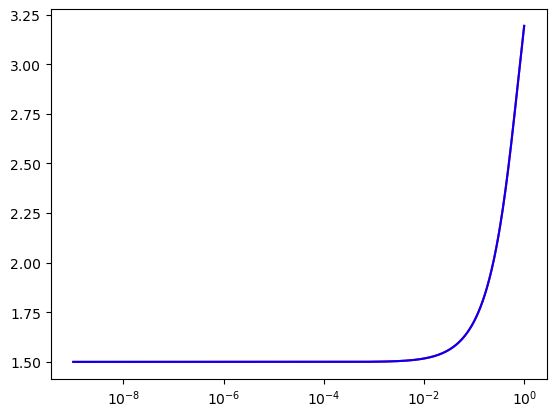

In [18]:
k = 1
a_0 = 1e-9
Omg_rad = (1 + (7/8) * (4/11)**(4/3)*3.046)*9.227e-5
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 0]

funct = lambda x,y: solution_coupled(x,y, cosmo, k)
soln = solve_ivp(funct,(a_0,1), np.array([3/2,1,1/2,-k*a_0/(6*Easquared(a_0, cosmo)), a_0/(2*Easquared(a_0, cosmo))]), \
                 t_eval=np.logspace(np.log10(a_0), 0, 500), method ='LSODA', rtol =1e-14)

plt.plot(soln.t,soln.y[0], color="r")

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 0]

funct1 = lambda x,y: solution_coupled(x,y, cosmo, k)
soln1 = solve_ivp(funct1,(a_0,1), np.array([3*(1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2,1,(1-2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/2,-k*a_0*(1+2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/(6*Easquared(a_0, cosmo)), a_0*(1+2*cosmo[-1]/(cosmo[-2]+cosmo[-1]))/(2*Easquared(a_0, cosmo))]),\
                  t_eval=np.logspace(np.log10(a_0), 0, 1000), method ='LSODA', rtol =1e-14)

plt.plot(soln1.t,soln1.y[0], color="b")

#plt.xlim(1e-10,1)
#plt.ylim(0,2)
plt.xscale("log")

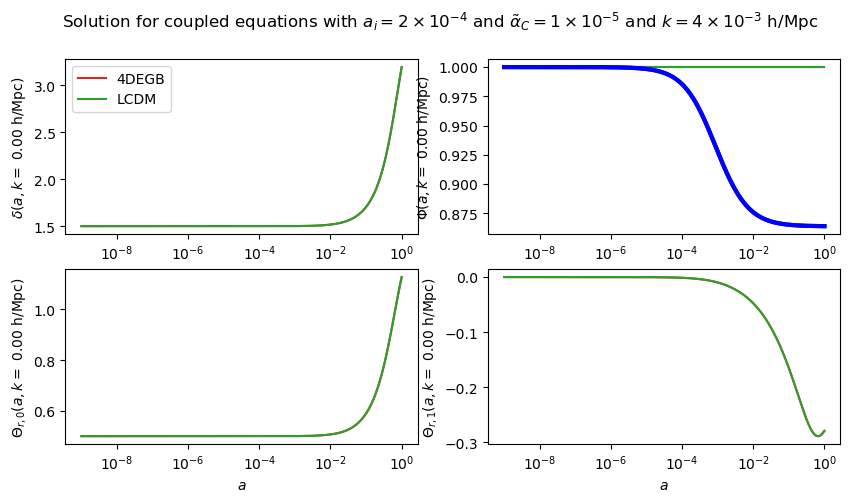

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle(r'Solution for coupled equations with $a_i = 2 \times 10^{-4}$ and $\tilde{\alpha}_C = 1 \times 10^{-5}$ and $k = 4 \times 10^{-3}$ h/Mpc')

ax1.plot(soln1.t,soln1.y[0], 'tab:red', label = "4DEGB")
ax1.set_ylabel(r"$\delta(a, k= $ %.2f h/Mpc)" % float(k/3e3))
ax1.set_xlabel(r"$a$")

ax2.plot(soln1.t,soln1.y[1], 'tab:red')
ax2.set_ylabel(r"$\Phi(a, k= $ %.2f h/Mpc)" % float(k/3e3))
ax2.set_xlabel(r"$a$")

ax3.plot(soln1.t,soln1.y[2], 'tab:red')
ax3.set_ylabel(r"$\Theta_{r,0}(a, k= $ %.2f h/Mpc)" % float(k/3e3))
ax3.set_xlabel(r"$a$")

ax4.plot(soln1.t,soln1.y[3], 'tab:red')
ax4.set_ylabel(r"$\Theta_{r,1}(a, k= $ %.2f h/Mpc)" % float(k/3e3))
ax4.set_xlabel(r"$a$")

ax1.plot(soln.t,soln.y[0], 'tab:green', label = "LCDM")
ax2.plot(soln.t,soln.y[1], 'tab:green')
ax3.plot(soln.t,soln.y[2], 'tab:green')
ax4.plot(soln.t,soln.y[3], 'tab:green')

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 1e-5]
ax2.plot(soln.t, phi_funct_lowk(soln.t,k,cosmo), color="b",linewidth=3)
ax2.plot(soln.t, phi_funct_lowk(soln.t,k,cosmo), color="b",linewidth=3)

#ax2.plot(soln.t, phi_funct_firstorderk(soln.t,k,[0.264 , 0.0493 , 0 , Omg_rad, 0])/phi_funct_firstorderk(soln.t,k,[0.264 , 0.0493 , 0 , Omg_rad, 0])[0], color="g",linewidth=3)

ax1.set_xscale("log")
#ax1.set_ylim(-6,100)
#ax1.set_xlim(1e-7,1e-4)
ax2.set_xscale("log")
#ax2.set_xlim(1e-7,1e-2)
#ax2.set_ylim(-10,10)
ax3.set_xscale("log")
#ax3.set_xlim(1e-7,1e-4)
#ax3.set_ylim(-3.5,3.5)
ax4.set_xscale("log")
#ax4.set_xlim(1e-6,1e-4)

ax1.legend()


#plt.savefig("numerical_soln_coupled1")

0.9813542834746795
1.361060797977684


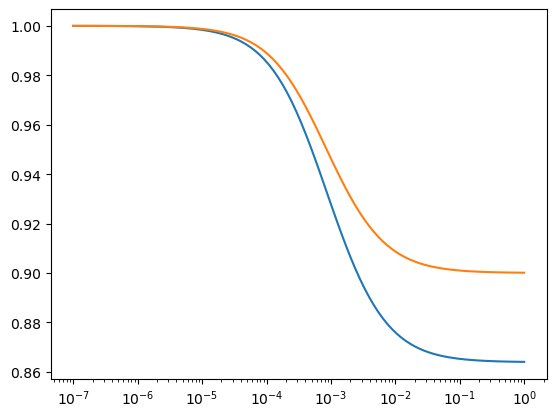

In [21]:
alpha_C = 1e-5
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, alpha_C]
a = np.logspace(-7,0,100)
phi_EGB = phi_funct_lowk(a,k,[0.264 , 0.0493 , 0 , Omg_rad, 0])[0]*phi_funct_lowk(a,k,[0.264 , 0.0493 , 0 , Omg_rad, alpha_C])/\
                                                                                    phi_funct_lowk(a,k,[0.264 , 0.0493 , 0 , Omg_rad, alpha_C])[0]
plt.plot(a,phi_EGB)
plt.plot(a,phi_funct_lowk(a,k,[0.264 , 0.0493 , 0 , Omg_rad, 0]))
a_matterdom = ((cosmo[-1]+cosmo[-2])/(cosmo[0]+cosmo[1]))
phi_EGB_CMB = phi_EGB[find_nearest(a,1/1101)]
phi_GR_CMB = phi_funct_lowk(a,k,[0.264 , 0.0493 , 0 , Omg_rad, 0])[find_nearest(a,1/1101)]
phi_EGB_matterdom = phi_EGB[find_nearest(a,a_matterdom)]
phi_GR_matterdom = phi_funct_lowk(a,k,[0.264 , 0.0493 , 0 , Omg_rad, 0])[find_nearest(a,a_matterdom)]
print(phi_EGB_CMB/phi_GR_CMB)
print((phi_EGB_CMB - phi_EGB_matterdom)/(phi_GR_CMB - phi_GR_matterdom))
plt.xscale("log")

In [64]:
plt.plot(soln5_t,soln5_y1, color="b",alpha=1, label = r"numerical 4DEGB, $a(\eta_i) = 6\times 10^{-8}$")
plt.plot(soln1.t,soln1.y[1], color="b",alpha=0.7, label = r"numerical 4DEGB, $a(\eta_i) = 7\times 10^{-8}$")

plt.plot(soln2_t,soln2_y1, color="b",alpha=0.4, label = r"numerical 4DEGB, $a(\eta_i) = 10^{-7}$")
plt.plot(soln4_t,soln4_y1, color="b",alpha=0.3, label = r"numerical 4DEGB, $a(\eta_i) = 2\times 10^{-7}$")
plt.plot(soln3_t,soln3_y1, color="b",alpha=0.2, label = r"numerical 4DEGB, $a(\eta_i) = 3\times 10^{-7}$")
plt.plot(soln.t,soln.y[1], color="r", label = "LCDM")
#plt.plot(soln.t, phi_funct(soln.t,k,[0.264 , 0.0493 , 0 , Omg_rad, 0]))
plt.plot(soln1.t, phi_funct_lowk(soln1.t,k,[0.264 , 0.0493 , 0 , Omg_rad, 1e-6]), color="g", label = r"analytical 4DEGB")
#plt.plot(soln.t, phi_funct_lowk(soln.t,k,[0.264 , 0.0493 , 0 , Omg_rad, 1e-5]))
#plt.plot(soln1.t, phi_funct_lowk(soln1.t,k,cosmo))
plt.xscale("log")
plt.ylim(-0.5,4)
plt.xlim(1e-7,1e-4)
plt.text(2e-7,3.5,r"$\tilde{\alpha}_C = 10^{-6}$", fontsize =15)
plt.ylabel(r"$\Phi(a, k= $ %.2f h/Mpc)" % float(k/3e3))
plt.xlabel(r"$a$")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = (10,4)
#plt.savefig("numerical_soln_analytical")

NameError: name 'soln5_t' is not defined